<br>
<p style="text-align: left;"><img src='https://s3.amazonaws.com/weclouddata/images/logos/sunlife_logo.png' width='35%'></p>
<p style="text-align:left;"><font size='15'><b> Machine Learning - Model Pipeline and Persistence </b></font> <br>
<h2 align='left' > Sunlife Data Science Training </h2>

<h4 align='left'>  Prepared by: <img src='https://s3.amazonaws.com/weclouddata/images/logos/wcd_logo.png' width='15%'></h4>

---

In this lab, we will take the notebook from the `model interpretation` lab, and create `functions` to separate data loading, data pre-processing, and model fitting steps

## <font color='#FC7307'>  LAB - Telecom Customer Churn

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.externals import joblib

pd.set_option('display.max_columns', 100)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load Data

In [2]:
def load_data(dataset):
    try:
        df = pd.read_csv(dataset)
        return df
    except Exception as e:
        print(e)

In [3]:
df = load_data('https://s3.amazonaws.com/weclouddata/datasets/telecom/churn/watson_telecom_churn/Watson_Telco_Customer_Churn_Outlier.csv')

In [4]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


### Encode Target

In [5]:
def encode_target(df, colname):
    """encodd boolean target to 0/1"""
    df[colname]=df[colname].map({'No':0, 'Yes':1})
    return df

In [6]:
df = encode_target(df, 'Churn')

In [7]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0


### Missing Imputation

In [8]:
def impute(df, colname, replace):
    "missing imputer using series.fillna"
    df[colname] = df[colname].fillna(replace)
    return df

In [9]:
df = impute(df, 'TotalCharges', 0)

In [10]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Prepare Features

In [11]:
def data_split(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=2018)

    X_train.drop(columns='customerID')
    X_test.drop(columns='customerID')
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = data_split(df)

In [13]:
print(X_train.shape, y_train.shape)

(4930, 20) (4930, 1)


In [14]:
print(X_test.shape, y_test.shape)

(2113, 20) (2113, 1)


### Outliers

In [15]:
def capping(df, colname, upper_fence):
    df.loc[df[colname] > upper_fence, colname] = upper_fence
    return df

In [16]:
X_train = capping(X_train, 'MonthlyCharges', 143.58749999999998)
X_test = capping(X_test, 'MonthlyCharges', 143.58749999999998)

In [17]:
X_train[['MonthlyCharges']].describe()

,MonthlyCharges
count,4930.000000
mean,64.845837
std,30.103423
min,18.250000
25%,36.112500
50%,70.250000
75%,89.850000
max,143.587500


### Transformation

In [18]:
def sqrt_transform(df, colname):
    df[colname] = pd.to_numeric(df[colname], errors='coerce')
    df[colname+'_sqrt'] = np.sqrt((1 + df[colname]))
    df.drop(columns=[colname])
    return df

In [19]:
X_train = sqrt_transform(X_train, 'TotalCharges')
X_test = sqrt_transform(X_test, 'TotalCharges')

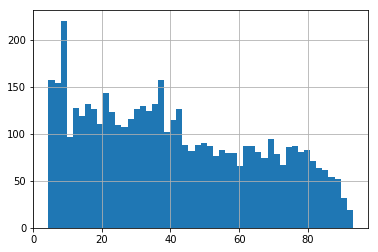

In [20]:
_ = X_train.TotalCharges_sqrt.hist(bins=50)

### Binning

In [21]:
def binning(df, colname, quantile_list, quantile_labels):
    df[colname+'_Qntl'] = pd.qcut(df[colname], 
                                  q=quantile_list,       
                                  labels=quantile_labels)
    df.drop(columns=[colname], inplace=True)
    return df

In [22]:
quantiles = [0, .25, .5, .75, 1.]
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']

In [23]:
X_train = binning(X_train, 'MonthlyCharges', quantiles, quantile_labels)

In [24]:
X_test = binning(X_test, 'MonthlyCharges', quantiles, quantile_labels)

In [25]:
X_train.dtypes

customerID               object
gender                   object
SeniorCitizen             int64
Partner                  object
Dependents               object
tenure                    int64
PhoneService             object
MultipleLines            object
InternetService          object
OnlineSecurity           object
OnlineBackup             object
DeviceProtection         object
TechSupport              object
StreamingTV              object
StreamingMovies          object
Contract                 object
PaperlessBilling         object
PaymentMethod            object
TotalCharges            float64
TotalCharges_sqrt       float64
MonthlyCharges_Qntl    category
dtype: object

### One hot encoding

In [26]:
cat_cols = X_train.iloc[:,1:].select_dtypes(include=['object']).columns.values
cat_cols

array(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype=object)

In [27]:
X_train_cat = X_train[cat_cols]
X_test_cat = X_test[cat_cols]

In [28]:
X_train_cat

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
4530,Female,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
5787,Female,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,No,Yes,Month-to-month,Yes,Electronic check
1946,Male,Yes,Yes,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic)
490,Male,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic)
5243,Male,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,Yes,One year,Yes,Credit card (automatic)
1241,Male,No,No,Yes,Yes,DSL,Yes,No,No,No,No,Yes,Month-to-month,Yes,Mailed check
3164,Male,No,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
6721,Female,Yes,Yes,Yes,Yes,DSL,No,Yes,No,Yes,Yes,Yes,Two year,No,Bank transfer (automatic)
888,Male,Yes,Yes,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,One year,No,Credit card (automatic)
3375,Female,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [30]:
!pip install sklearn_pandas

pyspark 2.3.1 requires py4j==0.10.7, which is not installed.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
lime 0.1.1.33 has requirement matplotlib==2.1.0, but you'll have matplotlib 3.0.3 which is incompatible.
awscli 1.16.81 has requirement botocore==1.12.71, but you'll have botocore 1.12.145 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper(
    [(d, LabelEncoder()) for d in cat_cols]
)

In [32]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[('gender', LabelEncoder()), ('Partner', LabelEncoder()), ('Dependents', LabelEncoder()), ('PhoneService', LabelEncoder()), ('MultipleLines', LabelEncoder()), ('InternetService', LabelEncoder()), ('OnlineSecurity', LabelEncoder()), ('OnlineBackup', LabelEncoder()), ('DeviceProtection', Labe...Contract', LabelEncoder()), ('PaperlessBilling', LabelEncoder()), ('PaymentMethod', LabelEncoder())],
        input_df=False, sparse=False)

In [33]:
pipe = Pipeline([
    ('label_encoder', mapper),
    ('ohe', OneHotEncoder()),
    ('rf', RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', random_state=2018))
])

### Fit the pipeline

In [34]:
pipe.fit(X_train_cat, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
     steps=[('label_encoder', DataFrameMapper(default=False, df_out=False,
        features=[('gender', LabelEncoder()), ('Partner', LabelEncoder()), ('Dependents', LabelEncoder()), ('PhoneService', LabelEncoder()), ('MultipleLines', LabelEncoder()), ('InternetService', LabelEncoder()), ('OnlineSecurity'...mators=500, n_jobs=1, oob_score=False, random_state=2018,
            verbose=0, warm_start=False))])

In [ ]:
# t = pipe.named_steps['label_encoder'].fit_transform(X_train)

### Use pipeline to make prediction

In [35]:
test_pred_proba = pipe.predict_proba(X_test)

In [36]:
test_pred_proba

array([[0.34378064, 0.65621936],
       [0.98420735, 0.01579265],
       [0.60700532, 0.39299468],
       ...,
       [0.942     , 0.058     ],
       [0.97301955, 0.02698045],
       [0.3078761 , 0.6921239 ]])

In [37]:
print(roc_auc_score(y_test, test_pred_proba[:,1]))

0.7857253573366105


### Save the model paramters and pipelines

In [38]:
joblib.dump(pipe, 'rf_model.joblib')

['rf_model.joblib']

### Load the pipelines and use for prediction

In [39]:
pipe = joblib.load('rf_model.joblib')

In [40]:
test_pred_proba = pipe.predict_proba(X_test)
print(roc_auc_score(y_test, test_pred_proba[:,1]))

0.7857253573366105
